In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/kaggle/nih-chest-xrays-tfrecords.zip", 'r')
zip_ref.extractall("/content/nih-chest-xrays-tfrecords")
zip_ref.close()

In [3]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 180 kB 51.8 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 140 kB 44.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=a89897b6899e46920e407a8c1e0f1042c4f114481a62e1b3e6eb12e5bc223120
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=d55d30d54c4426c654acd56d83b57cf01c1827bce9332a2efdc89b10352fab04
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [4]:
wandb.init(project="cnn_x_ray")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/nih-chest-xrays-tfrecords'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/nih-chest-xrays-tfrecords/preprocessed_data.csv
/content/nih-chest-xrays-tfrecords/data/053-438.tfrec
/content/nih-chest-xrays-tfrecords/data/120-438.tfrec
/content/nih-chest-xrays-tfrecords/data/096-438.tfrec
/content/nih-chest-xrays-tfrecords/data/088-438.tfrec
/content/nih-chest-xrays-tfrecords/data/196-438.tfrec
/content/nih-chest-xrays-tfrecords/data/098-438.tfrec
/content/nih-chest-xrays-tfrecords/data/009-438.tfrec
/content/nih-chest-xrays-tfrecords/data/081-438.tfrec
/content/nih-chest-xrays-tfrecords/data/069-438.tfrec
/content/nih-chest-xrays-tfrecords/data/202-438.tfrec
/content/nih-chest-xrays-tfrecords/data/172-438.tfrec
/content/nih-chest-xrays-tfrecords/data/119-438.tfrec
/content/nih-chest-xrays-tfrecords/data/199-438.tfrec
/content/nih-chest-xrays-tfrecords/data/213-438.tfrec
/content/nih-chest-xrays-tfrecords/data/219-438.tfrec
/content/nih-chest-xrays-tfrecords/data/040-438.tfrec
/content/nih-chest-xrays-tfrecords/data/177-438.tfrec
/content/nih-chest-xrays-

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from functools import partial
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks
import os
import random
import pprint
import pandas as pd
import numpy as np

In [7]:
df= pd.read_csv('/content/nih-chest-xrays-tfrecords/preprocessed_data.csv')

In [8]:
df.rename(columns = {'Unnamed: 0' : 'image'}, inplace = True)
df.head()

,image,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


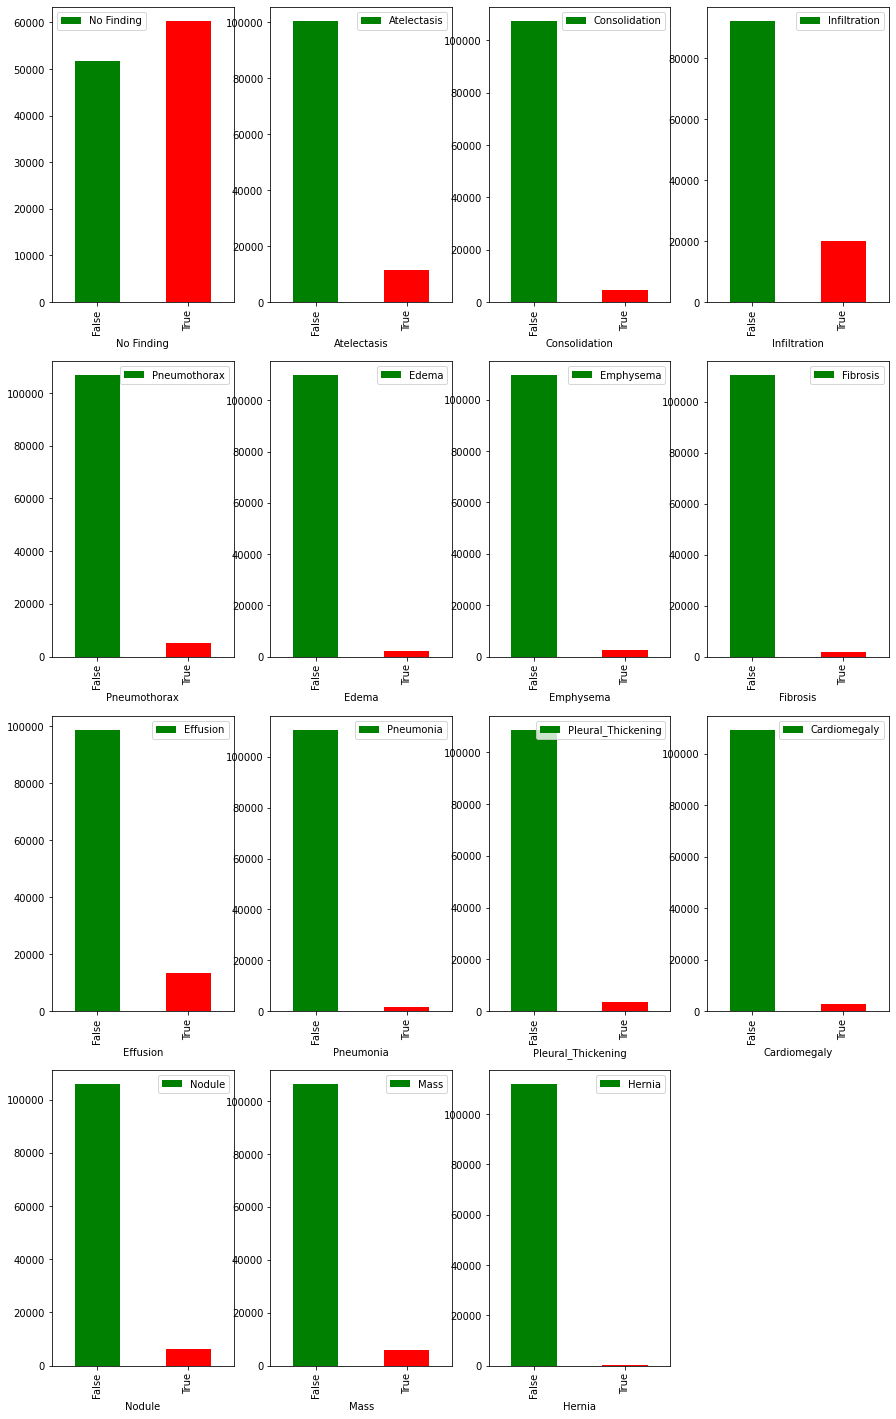

In [9]:
columns = df.columns[1:]
plt.figure(figsize = (15,25))

for j,i in zip(range(len(columns)), range(1,16)):
            plt.subplot(4,4,i)
            valeur = df.value_counts(columns[j],sort = False)
            valeur.plot.bar(label =columns[j], color = {'green': 'False', 'red': 'True'})
            plt.legend();

In [10]:
dossier = '/content/nih-chest-xrays-tfrecords/data/'
image = os.listdir(dossier)
img = [dossier+x for x in image]
filenames = tf.io.gfile.glob(img)

In [11]:
split_ind = int(0.8 * len(filenames))
split_ind2 = int(0.9 * len(filenames))

training= filenames[:split_ind]
valid = filenames[split_ind:split_ind2]
test = filenames[split_ind2:]

print("Train TFRecord Files:", len(training))
print("Validation TFRecord Files:", len(valid))
print("Test TFRecord Files:", len(test))
print(len(training)+len(valid)+len(test)==len(filenames))

Train TFRecord Files: 204
Validation TFRecord Files: 26
Test TFRecord Files: 26
True


In [12]:
feature_map= {}

for elem in list(df.columns)[1:]:
    feature_map[elem] = tf.io.FixedLenFeature([], tf.int64)
    
feature_map['image'] = tf.io.FixedLenFeature([], tf.string)
feature_map

{'Atelectasis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Cardiomegaly': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Consolidation': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Edema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Effusion': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Emphysema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Fibrosis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Hernia': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Infiltration': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Mass': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'No Finding': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Nodule': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pleural_Thickening': FixedLenFeature(shape=[], dtype=tf.int64, default_value=N

In [13]:
def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_map)
    image = tf.io.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, (150,150))
    image = tf.cast(image, tf.float32) / 255.0
    
    label = []
    
    for val in columns:
        label.append(example[val])
    
    return image, label

In [14]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    
    return dataset

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(64)
    
    return dataset

In [16]:
train_dataset = get_dataset(training)
valid_dataset = get_dataset(valid)
test_dataset = get_dataset(test)

In [17]:
eff = EfficientNetB1(include_top = False, input_shape=(150,150,3))
for layer in eff.layers:
    layer.trainable = False

27033600/27018416 [==============================] - 0s 0us/step


In [18]:
model = Sequential()
model.add(eff)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 5, 5, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [20]:
config = wandb.config
config.learning_rate = 0.01
model.compile(optimizer='adam', loss ='binary_crossentropy',
              metrics = [tf.keras.metrics.AUC(name="auc")])

In [21]:
plateau = callbacks.ReduceLROnPlateau(monitor='val_auc',
                                     patience = 1,
                                     factor = 0.01,
                                     mode = 'max')

early_stopping = callbacks.EarlyStopping(monitor = 'val_auc',
                                        patience = 3,
                                        restore_best_weights=True,
                                        mode = 'max')

In [26]:

model.fit(train_dataset, epochs = 1,
          callbacks=[[WandbCallback()],plateau, early_stopping,], validation_data=valid_dataset)

1396/1396 [==============================] - 331s 233ms/step - loss: 0.2200 - auc: 0.8273 - val_loss: 0.2180 - val_auc: 0.8311 - lr: 0.0010


In [23]:
model.evaluate(test_dataset)

178/178 [==============================] - 41s 197ms/step - loss: 0.2181 - auc: 0.8303


[0.21807734668254852, 0.8302568793296814]